In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns

Pytania:
1. Czy wszystkie wartości w df powinny być zmienione na duże litery? Jakie sa dobre praktyki?
2. Czy powinniśmy analizować tylko po vehicle 1 czy również vehicle 2 itd? 

# 1. Data loading

In [139]:
# Loading the CSV file with vehicle collision data and assigning the DataFrame to the variable 'vehicle_collision'
vehicle_collision = pd.read_csv('DataSets/nypd-motor-vehicle-collisions.csv',
                                dtype={
                                    'ZIP CODE': str,
                                    'CONTRIBUTING FACTOR VEHICLE 1': str,
                                    'CONTRIBUTING FACTOR VEHICLE 2': str
                                      }
                                )
pd.set_option('display.max_columns', None)
vehicle_collision.head(10)

,ACCIDENT DATE,ACCIDENT TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2019-08-05T00:00:00.000,16:30,QUEENS,11434,40.676052,-73.790184,"{'type': 'Point', 'coordinates': [-73.790184, ...",NaN,NaN,150-08 123 AVENUE,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4184637,Sedan,Pick-up Truck,NaN,NaN,NaN
1,2019-08-27T00:00:00.000,16:02,BROOKLYN,11225,40.657780,-73.951096,"{'type': 'Point', 'coordinates': [-73.951096, ...",NaN,NaN,288 HAWTHORNE STREET,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,2019-08-15T00:00:00.000,17:57,MANHATTAN,10002,40.718143,-73.993835,"{'type': 'Point', 'coordinates': [-73.993835, ...",CHRYSTIE STREET,GRAND STREET,NaN,1.0,0.0,0,0,0,0,1,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,4202457,Sedan,NaN,NaN,NaN,NaN
3,2019-08-30T00:00:00.000,21:53,BRONX,10460,40.840534,-73.866610,"{'type': 'Point', 'coordinates': [-73.86661, 4...",NaN,NaN,1837 EAST TREMONT AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4198749,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,2019-08-06T00:00:00.000,9:45,MANHATTAN,10016,40.745440,-73.975400,"{'type': 'Point', 'coordinates': [-73.9754, 40...",EAST 35 STREET,2 AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4183798,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
5,2019-08-29T00:00:00.000,12:28,BROOKLYN,11222,40.726524,-73.946390,"{'type': 'Point', 'coordinates': [-73.94639, 4...",NaN,NaN,38 JEWEL STREET,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4196772,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
6,2019-08-31T00:00:00.000,2:16,QUEENS,11434,40.667522,-73.780630,"{'type': 'Point', 'coordinates': [-73.78063, 4...",ROCKAWAY BOULEVARD,NORTH CONDUIT AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4198571,Sedan,NaN,NaN,NaN,NaN
7,2019-08-11T00:00:00.000,22:23,NaN,NaN,40.858210,-73.916790,"{'type': 'Point', 'coordinates': [-73.91679, 4...",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,0.0,1.0,0,0,0,0,0,1,Unsafe Speed,Unspecified,NaN,NaN,NaN,4187134,Motorcycle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
8,2019-08-02T00:00:00.000,16:30,QUEENS,11434,40.666492,-73.765360,"{'type': 'Point', 'coordinates': [-73.76536, 4...",SOUTH CONDUIT AVENUE,179 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Reaction to Uninvolved Vehicle,Unspecified,NaN,NaN,NaN,4181743,Pick-up Truck,Pick-up Truck,NaN,NaN,NaN
9,2019-08-21T00:00:00.000,17:30,BRONX,10452,40.837720,-73.927630,"{'type': 'Point', 'coordinates': [-73.92763, 4...",WEST 167 STREET,UNIVERSITY AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4198173,Sedan,NaN,NaN,NaN,NaN


## Displaying information about the DataFrame

In [140]:
vehicle_collision.info()
# The table contains 29 columns and 1,612,178 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612178 entries, 0 to 1612177
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   ACCIDENT DATE                  1612178 non-null  object 
 1   ACCIDENT TIME                  1612178 non-null  object 
 2   BOROUGH                        1127553 non-null  object 
 3   ZIP CODE                       1127376 non-null  object 
 4   LATITUDE                       1415893 non-null  float64
 5   LONGITUDE                      1415893 non-null  float64
 6   LOCATION                       1415893 non-null  object 
 7   ON STREET NAME                 1298002 non-null  object 
 8   CROSS STREET NAME              1079193 non-null  object 
 9   OFF STREET NAME                219732 non-null   object 
 10  NUMBER OF PERSONS INJURED      1612161 non-null  float64
 11  NUMBER OF PERSONS KILLED       1612145 non-null  float64
 12  NUMBER OF PEDE

In [141]:
# Displaying statistics for the DataFrame
vehicle_collision.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID
count,1.415893e+06,1.415893e+06,1.612161e+06,1.612145e+06,1.612178e+06,1.612178e+06,1.612178e+06,1.612178e+06,1.612178e+06,1.612178e+06,1.612178e+06
mean,4.068864e+01,-7.386657e+01,2.631363e-01,1.185998e-03,5.060483e-02,6.302034e-04,2.098590e-02,9.242156e-05,1.916854e-01,4.633483e-04,2.765946e+06
std,1.200403e+00,2.438640e+00,6.584832e-01,3.644859e-02,2.316972e-01,2.577872e-02,1.445222e-01,9.677481e-03,6.206497e-01,2.334547e-02,1.506373e+06
min,0.000000e+00,-2.012371e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01
25%,4.066882e+01,-7.397746e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.014464e+06
50%,4.072258e+01,-7.393002e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.422826e+06
75%,4.076789e+01,-7.386727e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.854210e+06
max,4.231832e+01,0.000000e+00,3.100000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,3.100000e+01,5.000000e+00,4.249104e+06


In [142]:
# Displaying missing values NaN (Not a Number)
vehicle_collision.isnull().sum()

ACCIDENT DATE                          0
ACCIDENT TIME                          0
BOROUGH                           484625
ZIP CODE                          484802
LATITUDE                          196285
LONGITUDE                         196285
LOCATION                          196285
ON STREET NAME                    314176
CROSS STREET NAME                 532985
OFF STREET NAME                  1392446
NUMBER OF PERSONS INJURED             17
NUMBER OF PERSONS KILLED              33
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       4324
CONTRIBUTING FACTOR VEHICLE 2     216051
CONTRIBUTING FACTOR VEHICLE 3    1507924
CONTRIBUTING FACTOR VEHICLE 4    1590389
CONTRIBUTING FACTOR VEHICLE 5    1606556
COLLISION_ID                           0
VEHICLE TYPE COD

# 2. Data cleaning

## Removing duplicates

In [143]:
# Displaying rows in the DataFrame with duplicates and sorting by "COLLISION_ID" column
display(f"Number of unique values in the COLLISION_ID column: {len(vehicle_collision.loc[:, 'COLLISION_ID'].unique())}")
vehicle_collision_duplicates = vehicle_collision[vehicle_collision.duplicated(subset='COLLISION_ID', keep=False)]
vehicle_collision_duplicates = vehicle_collision_duplicates.sort_values(by='COLLISION_ID', ascending=True)
vehicle_collision_duplicates.head(10)

'Number of unique values in the COLLISION_ID column: 1217957'

,ACCIDENT DATE,ACCIDENT TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
1611396,2012-07-02T00:00:00.000,14:25,MANHATTAN,10013,40.720376,-74.003261,"{'type': 'Point', 'coordinates': [-74.0032612,...",CANAL STREET,GREENE STREET,NaN,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,40,VAN,BICYCLE,NaN,NaN,NaN
832085,2012-07-02T00:00:00.000,14:25,MANHATTAN,10013,40.720376,-74.003261,"{'type': 'Point', 'coordinates': [-74.0032612,...",CANAL STREET,GREENE STREET,NaN,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,40,VAN,BICYCLE,NaN,NaN,NaN
1611967,2012-07-03T00:00:00.000,17:43,MANHATTAN,10013,40.725841,-74.007558,"{'type': 'Point', 'coordinates': [-74.0075584,...",SPRING STREET,HUDSON STREET,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,58,VAN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
832699,2012-07-03T00:00:00.000,17:43,MANHATTAN,10013,40.725841,-74.007558,"{'type': 'Point', 'coordinates': [-74.0075584,...",SPRING STREET,HUDSON STREET,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,58,VAN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
659346,2012-07-05T00:00:00.000,12:51,MANHATTAN,10004,40.702408,-74.012825,"{'type': 'Point', 'coordinates': [-74.012825, ...",WHITEHALL STREET,STATE STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,64,LIVERY VEHICLE,LIVERY VEHICLE,NaN,NaN,NaN
1610878,2012-07-05T00:00:00.000,12:51,MANHATTAN,10004,40.702408,-74.012825,"{'type': 'Point', 'coordinates': [-74.012825, ...",WHITEHALL STREET,STATE STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,64,LIVERY VEHICLE,LIVERY VEHICLE,NaN,NaN,NaN
658439,2012-07-05T00:00:00.000,9:05,MANHATTAN,10013,40.723626,-74.004788,"{'type': 'Point', 'coordinates': [-74.0047875,...",WATTS STREET,AVENUE OF THE AMERICAS,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,66,VAN,LARGE COM VEH(6 OR MORE TIRES),NaN,NaN,NaN
1610042,2012-07-05T00:00:00.000,9:05,MANHATTAN,10013,40.723626,-74.004788,"{'type': 'Point', 'coordinates': [-74.0047875,...",WATTS STREET,AVENUE OF THE AMERICAS,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,66,VAN,LARGE COM VEH(6 OR MORE TIRES),NaN,NaN,NaN
1610618,2012-07-05T00:00:00.000,22:10,MANHATTAN,10013,40.719778,-74.006807,"{'type': 'Point', 'coordinates': [-74.0068074,...",NORTH MOORE STREET,VARICK STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,68,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
659061,2012-07-05T00:00:00.000,22:10,MANHATTAN,10013,40.719778,-74.006807,"{'type': 'Point', 'coordinates': [-74.0068074,...",NORTH MOORE STREET,VARICK STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,68,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


In [144]:
# Removing duplicates based on the "COLLISION_ID" column
display(f"Before drop_duplicates: {len(vehicle_collision)}")
display(f"After drop_duplicates: {len(vehicle_collision.drop_duplicates(subset=['COLLISION_ID']))}")
vehicle_collision = vehicle_collision.drop_duplicates(subset=['COLLISION_ID'])

'Before drop_duplicates: 1612178'

'After drop_duplicates: 1217957'

## Removing empty rows

In [145]:
# No missing rows in the "COLLISION_ID" column
vehicle_collision['COLLISION_ID'].isnull().sum()

0

## Removing errors

In [146]:
# Removing human entry errors ('Illnes' -> 'Illness')
vehicle_collision['CONTRIBUTING FACTOR VEHICLE 1'] = vehicle_collision['CONTRIBUTING FACTOR VEHICLE 1'].replace('Illnes', 'Illness')

## Saving new data without duplicates

In [147]:
# Saving new dataframe without duplicates to csv
vehicle_collision.to_csv('DataSets/nypd_motor_vehicle_collisions_witout_duplicates.csv', index=False)

# 3. Data transformation

## Data formattng

In [148]:
# Formatting 'ACCIDENT DATE' to datetime type
vehicle_collision['ACCIDENT DATE'] = pd.to_datetime(vehicle_collision['ACCIDENT DATE'])

In [149]:
# Removing factors which are 'Unspecified' in 'Contributting factor vehicle 1' collumn
vehicle_collision_transformed = vehicle_collision[vehicle_collision['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
# vehicle_collision_transformed['CONTRIBUTING FACTOR VEHICLE 1'].unique()

In [150]:
# Capitalizing each entry in 'Contributing factor vehicle 1'
vehicle_collision_transformed.loc[:, 'CONTRIBUTING FACTOR VEHICLE 1'] = vehicle_collision_transformed['CONTRIBUTING FACTOR VEHICLE 1'].str.upper()
vehicle_collision_transformed.loc[:, 'CONTRIBUTING FACTOR VEHICLE 2'] = vehicle_collision_transformed['CONTRIBUTING FACTOR VEHICLE 2'].str.upper()

# 4. Results presentation

<Figure size 1000x600 with 0 Axes>

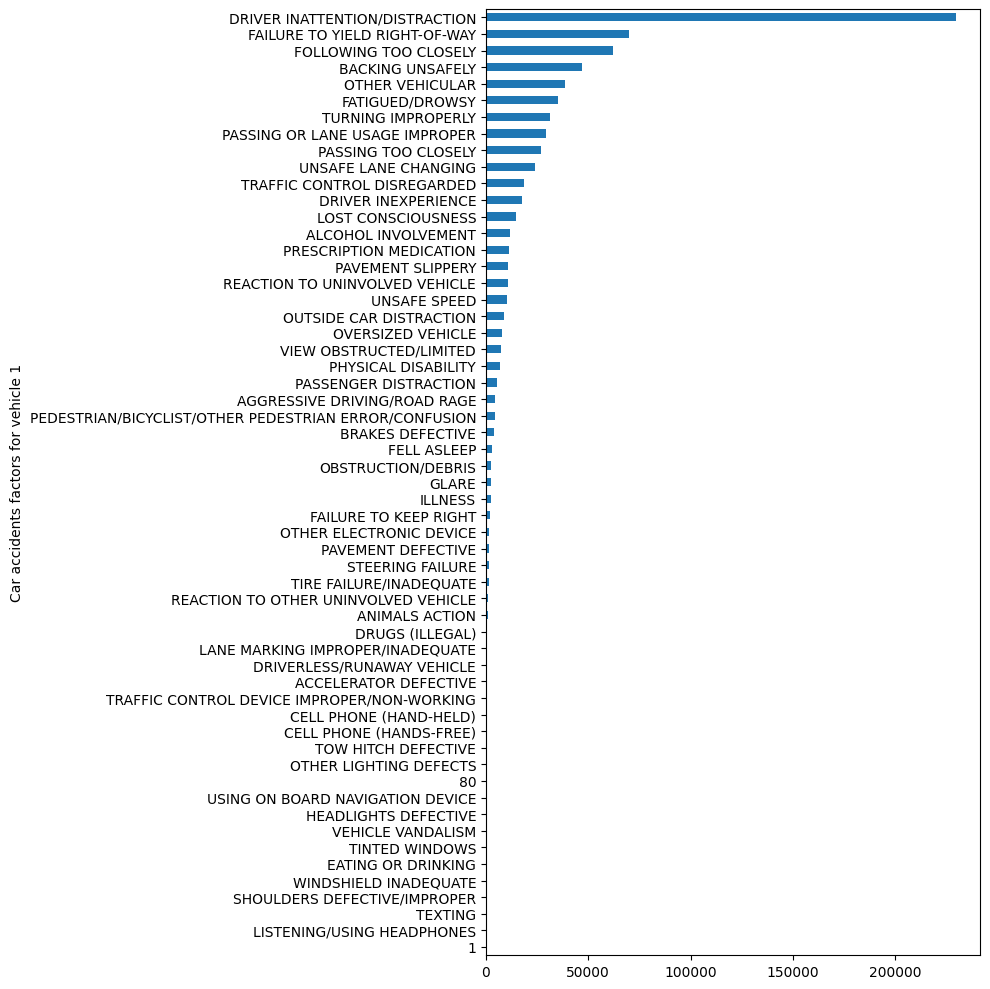

In [151]:
# Graphical visualization of car accidents factors for vehicle 1
plt.figure(figsize=(10, 10))
vehicle_collision_transformed['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().sort_values(ascending=True).plot(kind='barh')
# vehicle_collision_transformed['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.ylabel('Car accidents factors for vehicle 1')
plt.tight_layout()
plt.show()

## 4.1 Most dangerous factors by borough

In [152]:
# Grouping dataframe by 'borough' and 'contributing factor vehicle 1'
most_dangerous_factors = vehicle_collision_transformed.groupby(['BOROUGH','CONTRIBUTING FACTOR VEHICLE 1']).size()
# Grouping by 'n largest' contributing factors 
most_dangerous_factors = most_dangerous_factors.groupby(level=0).nlargest(1).reset_index(level=0, drop=True)
# Data visualization (data type: 'series')
most_dangerous_factors

BOROUGH        CONTRIBUTING FACTOR VEHICLE 1 
BRONX          DRIVER INATTENTION/DISTRACTION    17773
BROOKLYN       DRIVER INATTENTION/DISTRACTION    40747
MANHATTAN      DRIVER INATTENTION/DISTRACTION    40646
QUEENS         DRIVER INATTENTION/DISTRACTION    46255
STATEN ISLAND  DRIVER INATTENTION/DISTRACTION     6800
dtype: int64

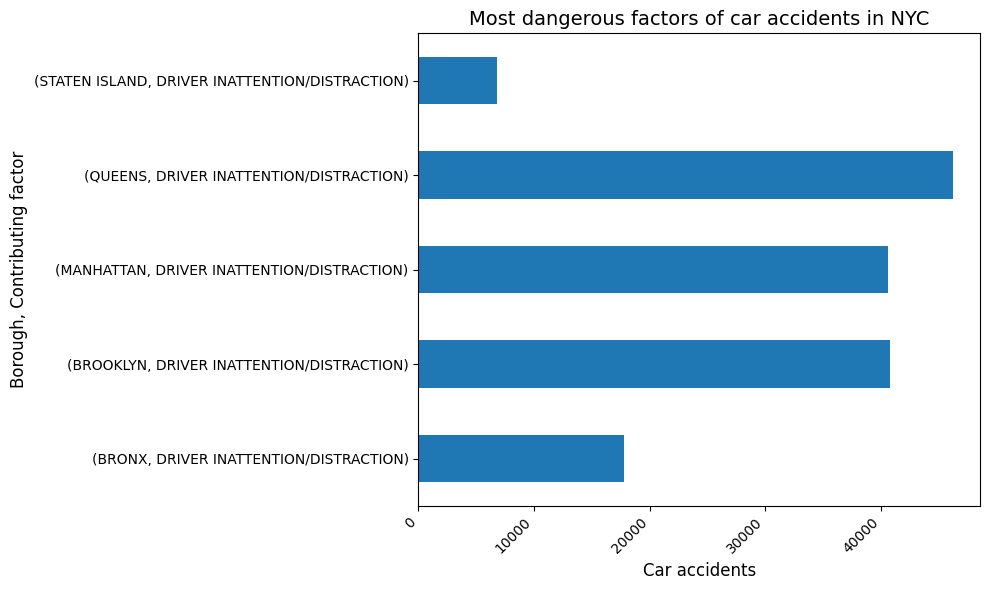

In [153]:
# Graphical visualization of most dangerous factors of car accidents in NYC
plt.figure(figsize = (10,6))
most_dangerous_factors.plot(kind='barh')
plt.title('Most dangerous factors of car accidents in NYC', fontsize=14)
plt.ylabel('Borough, Contributing factor', fontsize = 12)
plt.xlabel('Car accidents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4.2 Impact of speeding

In [154]:
# Selecting only rows with 'Unsafe Speed' factor
unsafe_speed_data = vehicle_collision_transformed[vehicle_collision_transformed['CONTRIBUTING FACTOR VEHICLE 1'] == 'UNSAFE SPEED']
# Grouping data by borough and summing up deaths and injuries
unsafe_speed_data = unsafe_speed_data.groupby('BOROUGH')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()
unsafe_speed_data

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED
BOROUGH,,
BRONX,682.0,3.0
BROOKLYN,1119.0,13.0
MANHATTAN,310.0,3.0
QUEENS,908.0,21.0
STATEN ISLAND,169.0,2.0


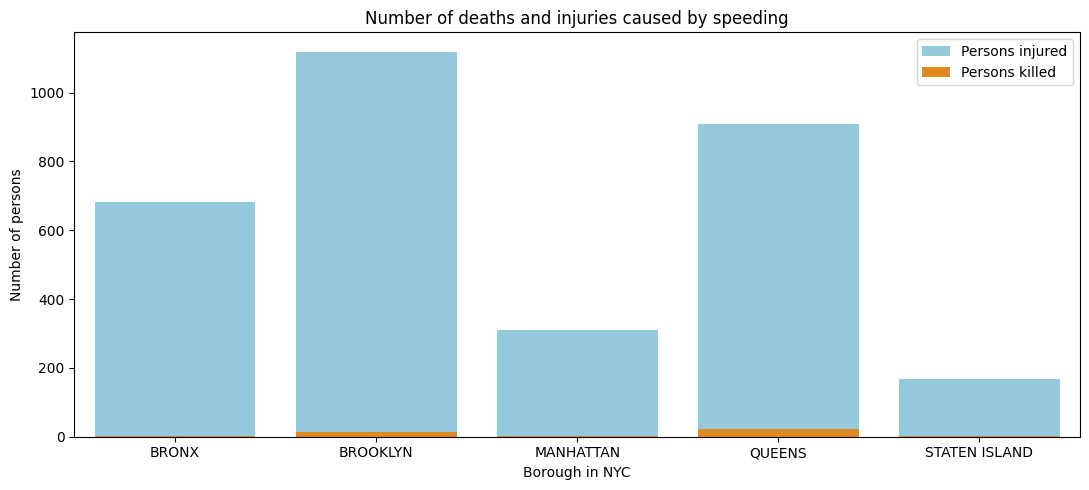

In [155]:
# Data vissualization using seaborn as sns
plt.figure(figsize=(11,5))
sns.barplot(data=unsafe_speed_data, x='BOROUGH', y='NUMBER OF PERSONS INJURED', color='skyblue', label='Persons injured')
sns.barplot(data=unsafe_speed_data, x='BOROUGH', y='NUMBER OF PERSONS KILLED', color='darkorange', label='Persons killed')
plt.title('Number of deaths and injuries caused by speeding')
plt.xlabel('Borough in NYC')
plt.ylabel('Number of persons')
plt.tight_layout()
plt.show()

In [156]:
# Another data visualization
fig = plt.figure(figsize=(10,6))
unsafe_speed_data.plot(kind='bar')
plt.title('Number of deaths and injuries caused by speeding')
plt.xlabel('Borough in NYC')
plt.ylabel('Number of persons')
plt.tight_layout()
plt.savefig('DataSets/Number_of_deaths_and_injuries.png')
plt.close()
# Showing graph on the middle of the screen
HTML("""
<div style="display: flex; justify-content: center;">
    <img src="DataSets/Number_of_deaths_and_injuries.png" alt="Wykres">
</div>
""")

In [157]:
# Saving new dataframe without duplicates to csv
unsafe_speed_data.to_csv('DataSets/unsafe_speed_data.csv')

## 4.3 Top accident factors